## Neural Network v2 Implementation  22nd August 2025

## Importing Dependencies

In [ ]:
import numpy as np
from utils import random_init, compute_validation_loss
from optim.SGD import SGD
from optim.Adam import Adam
from optim.RMSprop import RMSprop
from activation_func.activations import relu, cross_entropy_from_logits, sigmoid
from keras.datasets import mnist
from nn import nn

2025-08-31 17:38:45.357832: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-31 17:38:45.449949: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-31 17:38:49.301840: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-31 17:39:23.463989: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

## Training Loop MNIST Neural Network

In [13]:
# Load and preprocess data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Making a validation set
X_val = X_train[-10240:,]
y_val = y_train[-10240:]

X_train = X_train[:-10240]
y_train = y_train[:-10240]

# Normalize and reshape
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# Parameters
layers_dim = [784, 128, 64, 10]

# Random initialization of parameters
params = random_init(layers_dim)
model = nn(params)

# Mini batch
batch_size = 64
m = X_train.shape[0]
m_val = X_val.shape[0]

num_indices = m // batch_size
num_indices_val = m_val // batch_size

epochs = 30
lr = 1e-2
optimizer = RMSprop(params, lr)
activations = [relu, relu, relu, relu, relu]

# best config 1e-2 15epoch adam 64bs 99.6%
# 2nd best config 1e-2 15 epoch rmsprop 64bs 99.88%
for epoch in range(epochs):
    # Shuffle on each epoch
    perm = np.random.permutation(m)
    X_shuffled = X_train[perm, :]
    y_shuffled = y_train[perm,]

    perm_val = np.random.permutation(m_val)
    X_val_shuffled = X_val[perm_val, :]
    y_val_shuffled = y_val[perm_val,]
    
    epoch_loss = 0.0
    epoch_loss_val = 0.0 

    # Training Loop
    for i in range(num_indices):
        start = i * batch_size
        end = start + batch_size
        X_batch = X_shuffled[start:end, :]
        y_batch = y_shuffled[start:end,]

        # Forward pass
        Z, cache = model.forward(X_batch, activations)

        # Compute loss
        loss, dZ3 = cross_entropy_from_logits(Z, y_batch)
        
        # sum over samples
        epoch_loss += loss * X_batch.shape[0]  
        
        # Backward pass
        gradients = model.backward(y_batch, dZ3, cache, activations)
 
        # Update weights 
        params = optimizer.step(gradients)
        
    # Validation Loop
    for i in range(num_indices_val):
        start = i * batch_size
        end = start + batch_size 

        X_val_batch = X_val_shuffled[start:end, :]
        y_val_batch = y_val_shuffled[start:end,]

        val_loss = compute_validation_loss(model, X_val_batch, y_val_batch, activations, batch_norm = False)
        epoch_loss_val += val_loss * X_val_batch.shape[0]
        
    epoch_loss /= m
    epoch_loss_val /= m
    train_acc = model.accuracy(X_train, y_train, activations, batch_norm = False)
    val_acc = model.accuracy(X_val, y_val, activations, batch_norm = False)
    
    print(f"Epochs: {epoch+1}, Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_loss_val:.4f}, Train Acc: {train_acc * 100:.2f}, Val Acc: {val_acc * 100:.2f}")


Epochs: 1, Train Loss: 0.2929, Val Loss: 0.0308, Train Acc: 95.67, Val Acc: 95.74
Epochs: 2, Train Loss: 0.1398, Val Loss: 0.0257, Train Acc: 97.11, Val Acc: 96.48
Epochs: 3, Train Loss: 0.1039, Val Loss: 0.0268, Train Acc: 97.37, Val Acc: 96.40
Epochs: 4, Train Loss: 0.0889, Val Loss: 0.0257, Train Acc: 97.95, Val Acc: 96.48
Epochs: 5, Train Loss: 0.0770, Val Loss: 0.0244, Train Acc: 98.13, Val Acc: 96.83
Epochs: 6, Train Loss: 0.0681, Val Loss: 0.0295, Train Acc: 97.99, Val Acc: 96.70
Epochs: 7, Train Loss: 0.0568, Val Loss: 0.0248, Train Acc: 98.91, Val Acc: 97.25
Epochs: 8, Train Loss: 0.0541, Val Loss: 0.0269, Train Acc: 98.89, Val Acc: 97.30
Epochs: 9, Train Loss: 0.0477, Val Loss: 0.0285, Train Acc: 98.73, Val Acc: 97.22
Epochs: 10, Train Loss: 0.0433, Val Loss: 0.0258, Train Acc: 99.19, Val Acc: 97.46
Epochs: 11, Train Loss: 0.0416, Val Loss: 0.0303, Train Acc: 99.15, Val Acc: 97.24
Epochs: 12, Train Loss: 0.0361, Val Loss: 0.0345, Train Acc: 98.78, Val Acc: 97.02
Epochs: 13, T

## Test/Train Accuracy 

In [15]:
# Evaluate 
test_acc = model.accuracy(X_test, y_test, activations, batch_norm = False)
train_acc = model.accuracy(X_train, y_train, activations, batch_norm = False)

print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Train Accuracy: {train_acc * 100:.2f}%")

Test Accuracy: 97.60%
Train Accuracy: 99.78%


## Checking Model in Action with Images/logits

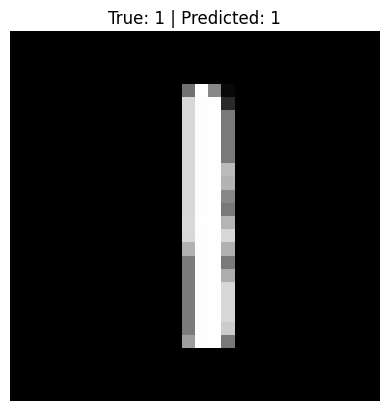

Probabilities: [ -9.683  28.664  -3.102   2.867   1.532 -10.072  -1.563  11.176   3.618
  -3.897]


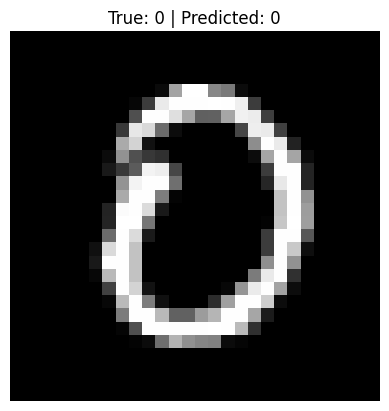

Probabilities: [ 28.285 -23.67   -5.476 -12.671   1.285 -15.586  -2.921  -6.9    -9.404
   1.035]


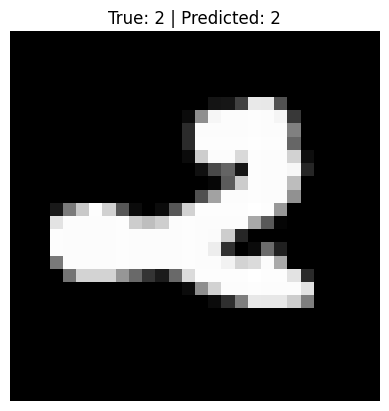

Probabilities: [-14.961 -11.243  22.201  -0.237   6.038   3.083  -7.44  -19.015 -21.275
   4.716]


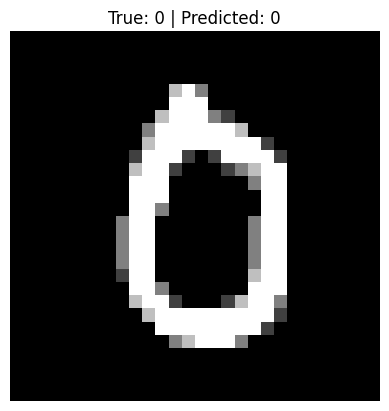

Probabilities: [ 21.936 -19.275  -6.881 -12.412  -2.806 -11.533  -3.355  -6.673 -11.817
  -2.652]


In [13]:
import matplotlib.pyplot as plt

def predict_single(X, params, model, acts):
    # forward returns (output, cache)
    probs, _ = model.forward(X[np.newaxis, :], acts)  
    y_pred = np.argmax(probs, axis=1)[0]   # axis=1 because batch dimension is first
    return y_pred, probs[0]

for i in range(1,5):
    idx = np.random.randint(0, X_test.shape[0])
    x_example = X_test[idx]
    y_true = y_test[idx]
    
    # Predict
    y_pred, probs = predict_single(x_example, params, model, activations)
    
    # Reshape and plot image (assuming 28x28)
    plt.imshow(x_example.reshape(28, 28), cmap='gray')
    plt.title(f"True: {y_true} | Predicted: {y_pred}")
    plt.axis('off')
    plt.show()
    
    print("Probabilities:", np.round(probs, 3))
    

In [5]:
%%time

import numpy as np
from utils import random_init, compute_validation_loss
from optim.SGD import SGD
from optim.Adam import Adam
from optim.RMSprop import RMSprop
from activation_func.activations import relu, cross_entropy_from_logits
from keras.datasets import mnist
from nn import nn

# Load and preprocess data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Making a validation set
X_val = X_train[-10240:,]
y_val = y_train[-10240:]

X_train = X_train[:-10240]
y_train = y_train[:-10240]

# Normalize and reshape
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# Parameters
layers_dim = [784, 32, 16, 10]

# Random initialization of parameters
params = random_init(layers_dim, batch_norm = True)

model = nn(params) 
activations = [relu, relu, relu, relu]
# Mini batch
batch_size = 64

m = X_train.shape[0]
m_val = X_val.shape[0]

num_indices = m // batch_size
num_indices_val = m_val // batch_size
epochs = 30
lr = 1e-2

# Optimizer
optimizer = Adam(params, lr, batch_norm = True)

for epoch in range(epochs):
    # Shuffle on each epoch
    perm = np.random.permutation(m)
    X_shuffled = X_train[perm, :]
    y_shuffled = y_train[perm,]
    
    perm_val = np.random.permutation(m_val)
    X_val_shuffled = X_val[perm_val, :]
    y_val_shuffled = y_val[perm_val,]
    
    epoch_loss = 0.0
    epoch_loss_val = 0.0
    # Training Loop
    for i in range(num_indices):
        start = i * batch_size
        end = start + batch_size
        X_batch = X_shuffled[start:end, :]
        y_batch = y_shuffled[start:end,]
        
        # Forward pass
        Z, cache = model.forward(X = X_batch, activations = activations, batch_norm = True, verbose = False)

        # Compute loss
        train_loss, dZ3 = cross_entropy_from_logits(Z, y_batch)
        
        # train loss
        epoch_loss += train_loss * X_batch.shape[0]
        
        # Backward pass
        gradients = model.backward(y_batch, dZ3, cache, activations, batch_norm = True)
 
        # Update weights
        params = optimizer.step(gradients)
    # Validation loop
    for i in range(num_indices_val):
        start = i * batch_size
        end =  start + batch_size
        X_val_batch = X_val_shuffled[start:end, :]
        y_val_batch = y_val_shuffled[start:end,]

        # val loss
        val_loss = compute_validation_loss(model, X_val_batch, y_val_batch, activations, batch_norm = True)
        epoch_loss_val += val_loss 
        
    epoch_loss /= m
    epoch_loss_val /= m_val
    
    train_acc = model.accuracy(X_train, y_train, activations, batch_norm = True)
    val_acc = model.accuracy(X_val, y_val, activations, batch_norm = True)
    print(f"Epochs: {epoch+1}, Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_loss_val:.4f}, Train Acc: {train_acc * 100:.2f}, Val Acc: {val_acc * 100:.2f}")


Epochs: 1, Train Loss: 0.3103, Val Loss: 0.0026, Train Acc: 95.08, Val Acc: 95.07
Epochs: 2, Train Loss: 0.1677, Val Loss: 0.0023, Train Acc: 96.40, Val Acc: 95.78
Epochs: 3, Train Loss: 0.1400, Val Loss: 0.0019, Train Acc: 97.32, Val Acc: 96.40
Epochs: 4, Train Loss: 0.1227, Val Loss: 0.0019, Train Acc: 97.50, Val Acc: 96.48
Epochs: 5, Train Loss: 0.1128, Val Loss: 0.0018, Train Acc: 97.64, Val Acc: 96.60
Epochs: 6, Train Loss: 0.1051, Val Loss: 0.0017, Train Acc: 97.99, Val Acc: 96.92
Epochs: 7, Train Loss: 0.0982, Val Loss: 0.0018, Train Acc: 98.00, Val Acc: 96.75
Epochs: 8, Train Loss: 0.0907, Val Loss: 0.0016, Train Acc: 98.33, Val Acc: 97.17
Epochs: 9, Train Loss: 0.0893, Val Loss: 0.0017, Train Acc: 98.38, Val Acc: 97.01
Epochs: 10, Train Loss: 0.0851, Val Loss: 0.0018, Train Acc: 98.32, Val Acc: 96.76
Epochs: 11, Train Loss: 0.0804, Val Loss: 0.0016, Train Acc: 98.57, Val Acc: 97.08
Epochs: 12, Train Loss: 0.0762, Val Loss: 0.0016, Train Acc: 98.71, Val Acc: 97.26
Epochs: 13, T

In [20]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np

# Set seed for reproducibility
tf.random.set_seed(0)
np.random.seed(0)

# Load and preprocess data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Define the model architecture using Sequential API
layers_dim = [784, 128, 64, 10]
model = Sequential()
model.add(Flatten(input_shape=(28, 28))) # Flattens the 28x28 image into a 784-element vector

# Add hidden layers with Batch Normalization and ReLU activation
for i in range(1, len(layers_dim) - 1):
    model.add(Dense(layers_dim[i]))
    #model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))

# Add the final output layer
model.add(Dense(layers_dim[-1]))

# Compile the model with the specified optimizer and loss
lr = 1e-2
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model, using a validation split to mimic the original code's validation set
epochs = 30
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=epochs,
    validation_split=10240/60000, 
    shuffle=True
)

Epoch 1/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9235 - loss: 0.2504 - val_accuracy: 0.9547 - val_loss: 0.1602
Epoch 2/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9570 - loss: 0.1476 - val_accuracy: 0.9539 - val_loss: 0.1843
Epoch 3/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9647 - loss: 0.1229 - val_accuracy: 0.9480 - val_loss: 0.2129
Epoch 4/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9669 - loss: 0.1196 - val_accuracy: 0.9665 - val_loss: 0.1470
Epoch 5/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9718 - loss: 0.0997 - val_accuracy: 0.9655 - val_loss: 0.1573
Epoch 6/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9740 - loss: 0.0925 - val_accuracy: 0.9647 - val_loss: 0.1790
Epoch 7/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9748 - loss: 0.0903 - val_accuracy: 0.9619 - val_loss: 0.1924
Epoch 8/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9747 - loss: 0.0972 - val_accuracy: 0.